In [51]:
#Import needed libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline


# Simple LSTM

In [52]:
#Import dataset 
colnames = ['Label', 'Message']
df = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
df.rename(columns={'v1': 'Label', 'v2':'Message'}, inplace=True)
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [53]:
#Preprocesssing Steps

#Seperate dataframe into different vectors
Inputs = df['Message']
Outputs = df['Label']

#Change the output vector to bianry data
labelencoder = LabelEncoder()
Outputs = labelencoder.fit_transform(Outputs)
Outputs = Outputs.reshape(-1,1)

#Split the data into different sets
#Train: 85% and testing: 15% 
X_train,X_test,Y_train,Y_test = train_test_split(Inputs,Outputs,test_size=0.15)

#Text Preprocessing
#Tokenize messages into sequences  
maxWords = 1000
maxWordLen = 150 
token = Tokenizer(num_words=maxWords) #WThis class allows to vectorize a text corpus
token.fit_on_texts(X_train)

#Tokenize Train Set
train_sequences = token.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=maxWordLen)

#Tokenize Test Set
test_sequences = token.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=maxWordLen)


In [54]:
#Define the architecture 
#define the layers
inputs = Input(name='inputs',shape=[maxWordLen])
layer = Embedding(maxWords,50,input_length=maxWordLen)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FullyConnected1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer) #forget to 50%
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)

#Create the model 
model = Model(inputs=inputs,outputs=layer)
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [55]:
#Train the model 
model.fit(train_sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3788 samples, validate on 948 samples
Epoch 1/10
3788/3788 [==============================] - 20s 5ms/sample - loss: 0.3135 - accuracy: 0.8762 - val_loss: 0.1296 - val_accuracy: 0.9673
Epoch 2/10
3788/3788 [==============================] - 16s 4ms/sample - loss: 0.0769 - accuracy: 0.9799 - val_loss: 0.0648 - val_accuracy: 0.9810
Epoch 3/10
3788/3788 [==============================] - 21s 6ms/sample - loss: 0.0430 - accuracy: 0.9876 - val_loss: 0.0637 - val_accuracy: 0.9821
Epoch 4/10
3788/3788 [==============================] - 15s 4ms/sample - loss: 0.0360 - accuracy: 0.9902 - val_loss: 0.0597 - val_accuracy: 0.9821
Epoch 5/10
3788/3788 [==============================] - 16s 4ms/sample - loss: 0.0237 - accuracy: 0.9942 - val_loss: 0.0758 - val_accuracy: 0.9810


In [56]:
#Evaluate model with the test Set 
accr = model.evaluate(test_sequences_matrix,Y_test)

836/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [57]:
#Predict and display metrics
y_pred = model.predict(test_sequences_matrix)
pr, rc, thresholds = precision_recall_curve(Y_test, y_pred)
crossover_index = np.max(np.where(pr <= rc))
crossover_cutoff = thresholds[crossover_index]
m_confusion_test = confusion_matrix(Y_test, y_pred > crossover_cutoff)

print(classification_report(Y_test, y_pred>crossover_cutoff))

display(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       732
           1       0.94      0.93      0.94       104

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.96       836
weighted avg       0.98      0.98      0.98       836



,Predicted 0,Predicted 1
Actual 0,726,6
Actual 1,7,97


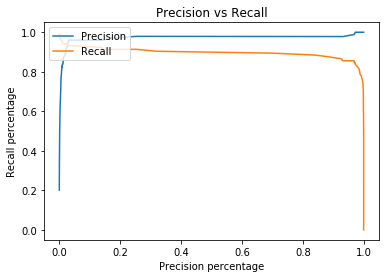

In [58]:
#Plot Precision vs Recall 
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.xlabel("Precision percentage")
plt.ylabel("Recall percentage")
plt.title("Precision vs Recall")
plt.legend(['Precision','Recall'], loc='upper left')
plt.show()